# <center> Импорт библоиотек <center>

*NOTE*: не забудьте соствить список библиотек, необходимых для реализации ваших решений, и представить их в файле `requirements.txt`.

In [1]:
import pickle
import random
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score , accuracy_score

# <center> Чтение данных <center>

Тренировчные данные представлены в виде файла в формате JSON. В котором верхенеуровневый ключ -- это номер образца (бакетрии). Каждый словарь по бактериям содержит название штамма и результаты масс-спектрометрического анализа, которые представлены следующими полями: масса к заряду (m/z), время (time), интенсивность пика (Intens.), разрешение (Res.), площадь пика (Area), относительная интенсивность (Rel. Intens.), ширина на полувысоте (FWHM=full width at half-maximum intensity). Каждый штамм будет представлен несколькими бактериями.

In [2]:
with open('train.json', 'rb') as fp:
    train_d = json.load(fp)
train_df = pd.DataFrame(json.loads(train_d)).T

In [3]:
train_df.shape

(256, 10)

In [4]:
## Посмотрим сколько классов данных и сколько примеров на каждый класс
train_df.groupby('strain').agg({'strain': "count"})

,strain
strain,
Acinetobacter baumani_121 skin,9
Acinetobacter baumani_126,9
Acinetobacter baumani_352 blood,10
Acinetobacter baumani_377 blood,11
Acinetobacter baumani_503 blood,11
Acinetobacter baumani_63,9
Acinetobacter baumani_64,11
Acinetobacter baumani_73,10
Acinetobacter baumani_74,11


Так как тренировочный набор данных не очень большой, дополним его симмулированными данными. Для этого составим дополнительные примеры из существующих. Зададим seed для воспроизводимости результатов.

In [ ]:
# для начала орпеделим количестов пиков в масс-спектрах
train_df.loc[:,'n_peak'] = train_df['m/z'].apply(len)

In [ ]:
def get_dif(x):
    return max(x) - min(x)

In [20]:
# посмотрим на сколько по количеству строк (пиков) различаются таблицы внутри каждого штамма
peaks_dif = train_df.groupby(['strain']).agg({'n_peak': get_dif})

In [ ]:
sns.histplot(peaks_dif.n_peak)

In [40]:
# будем использовать среднюю разности для варьирвания числа пиков в сгенерированных данных
mean_dif = int(peaks_dif.n_peak.mean()) 

In [41]:
FEATURES = ['m/z', 'time', 'Intens.', 'SN', 'Res.', 'Area', 'Rel. Intens.', 'FWHM', 'Bk. Peak']

In [42]:
np.random.seed(142)
train_gen = pd.DataFrame()
for strain in train_df.strain.unique():
    tmp = train_df[train_df.strain == strain]
    n_samples = tmp.shape[0]
    s = np.random.randint(max(tmp.n_peak) - mean_dif, max(tmp.n_peak), 6)
    strain_df = pd.DataFrame()
    
    for i,sample in enumerate(tmp[FEATURES].values):
        tmp_i = pd.DataFrame(list(sample)).T
        tmp_i.columns = FEATURES
        strain_df = pd.concat([ strain_df, tmp_i])
    for i in range(0,6):
        df_i = pd.DataFrame()
        idx = []
        for n in range(0,s[i]):
            if isinstance(strain_df.loc[n], pd.Series):
                continue
            else:
                df_i = pd.concat([df_i, strain_df.loc[n].sample(n=1)])
        df_i[['id']] = i
        df_i.loc[:, 'strain'] = tmp.strain.unique()[0]
        df_i.loc[:, 'n_peak'] = n
        train_gen = pd.concat([train_gen, df_i])        

In [43]:
train_gen.shape

(12396, 12)

In [44]:
train_gen = train_gen.groupby(['strain', 'id']).agg(list).reset_index().drop(['id'], axis = 1)
train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)

Совместим оригинальных датасет и сгенерированный.

In [45]:
train_df = pd.concat([train_df, train_gen[train_df.columns]])

In [46]:
train_df.shape

(568, 11)

# <center> Обработка данных и генерация признаков<center>

Пример таблицы с данными по масс-спектру для одного образца

In [47]:
example = train_df[FEATURES]\
         .loc[(train_df.strain == 'Staphilococcus aureus_6 1006')].iloc[0]
example = pd.DataFrame(list(example)).T
example.columns = FEATURES

In [48]:
example.head()

,m/z,time,Intens.,SN,Res.,Area,Rel. Intens.,FWHM,Bk. Peak
0,2141.595860,46248.308185,1849.671417,5.023842,449.793188,13621.062834,0.084247,4.761290,0.0
1,2154.140758,46381.493984,1299.384644,3.529223,458.732871,9421.672911,0.059183,4.695850,0.0
2,2180.436755,46659.416149,1203.332001,3.317415,443.973316,9161.078120,0.054808,4.911189,0.0
3,2297.759326,47879.408034,1426.807159,3.967446,620.345018,9085.341876,0.064987,3.704002,0.0
4,2764.201381,52445.360112,1586.883118,4.470495,629.209920,12546.815080,0.072278,4.393131,0.0


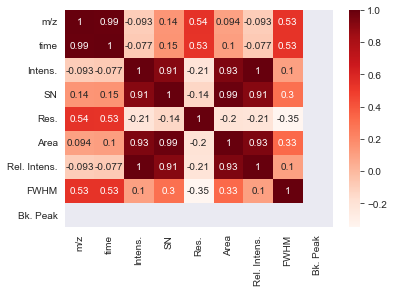

In [49]:
cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [50]:
## select uncorrelated features
FEATURES = ['m/z', 'Rel. Intens.', 'Res.', 'FWHM']

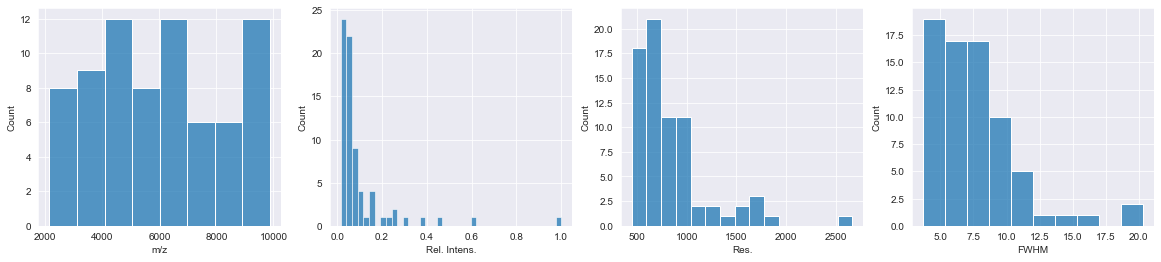

In [51]:
fig, axs = plt.subplots(1,4, figsize=(20, 4))
for features in FEATURES:
    sns.histplot(example[features], ax = axs[FEATURES.index(features)])

Посмотрим на масс-спектры для нескольих примеров

In [52]:
def colors_from_values(values, palette_name):
    values = np.array(values)
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

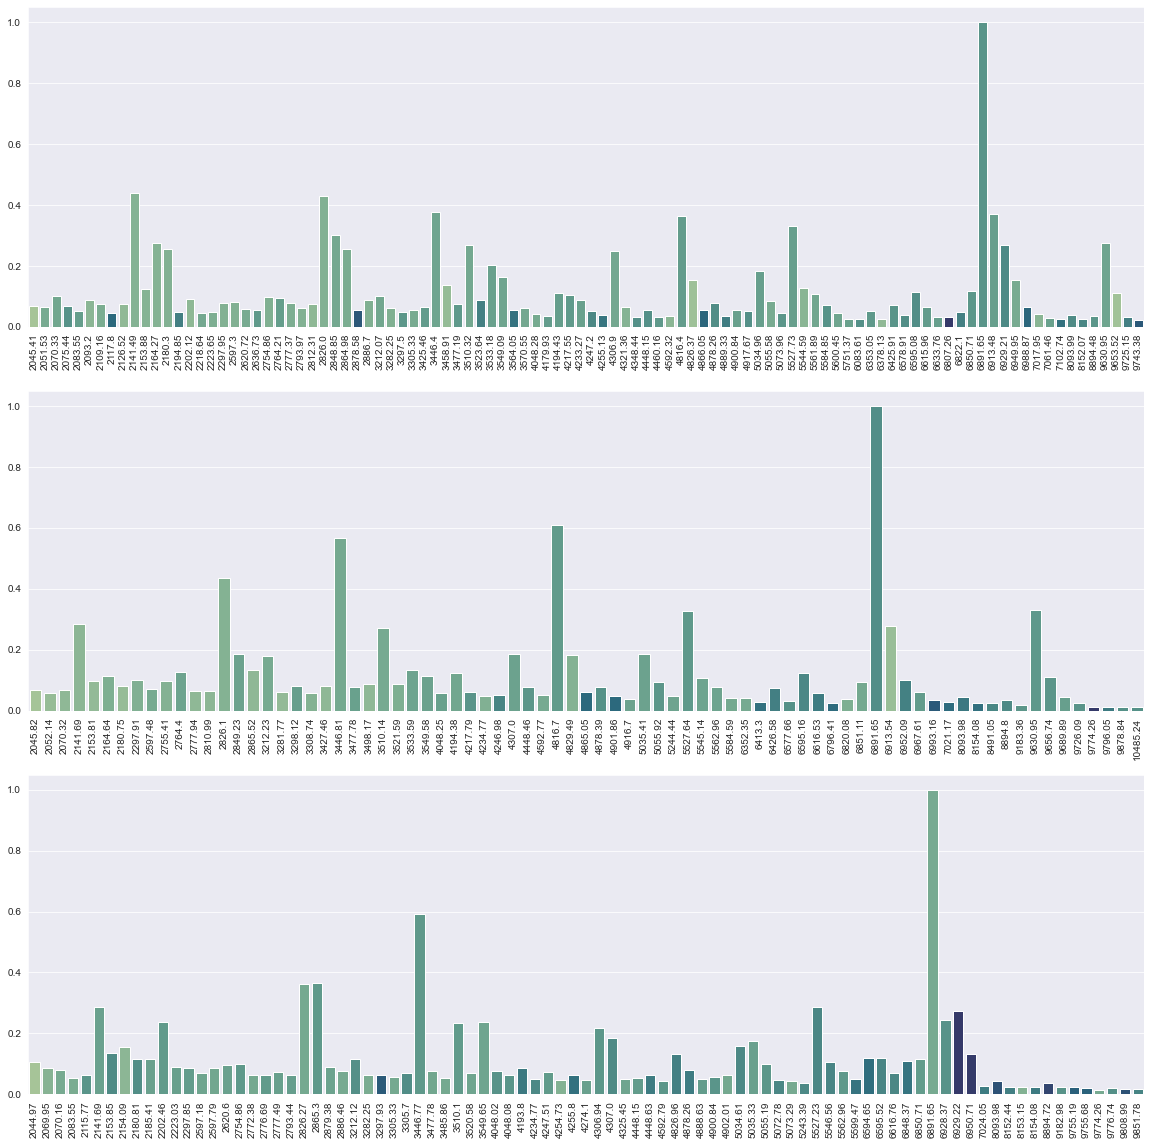

In [53]:
fig, axs = plt.subplots(3,1, figsize=(20,20))
satain = "Acinetobacter baumani_64"
i = 0
for ids in [2,6,8]:
    tmp = train_df.loc[(train_df.strain == strain)].iloc[ids]
    mz = [np.round(x, 2) for x in tmp['m/z']]
    ax =  axs[i]
    sns.barplot(data = tmp, x=mz, y = 'Rel. Intens.', 
                palette=colors_from_values(tmp['Res.'], 'crest'),
                ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    i=i+1

Создаим спектры, которые удобно сравнитвать между собой в виде векторов в фиксированом диапазоне, и уберем необходимость использовать переменную "m/z".

In [54]:
# орпеделим диапазон парамтеров
min(train_df['m/z'].apply(min)), max(train_df['m/z'].apply(max))

(2040.804289776974, 17241.93492389016)

In [55]:
def create_speactr(mz, intens):
    spec = []
    for i in range(200, 1750):
        if i in mz:
            spec.append(intens[mz.index(i)])
        else:
            spec.append(0)
    return spec

In [56]:
def prepocess_data(data):
    data['mz'] = data['m/z'].apply(lambda x: [int(x_i // 10) for x_i in x])
    data['intens'] = data.apply(lambda d: create_speactr(d['mz'], d['Rel. Intens.']),
                           axis = 1)
    return data

In [57]:
train_df = prepocess_data(train_df)

Перемешаем данные, чтобы классы не шли по порядку

In [58]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# <center> Обучение моделей <center>

Разобьем выборку на валидационную и тренировочную так, чтобы хотя бы один пример из каждого класса присутствавал
в валидаицонной выборке. После разбиения уберем два класса из тренировочный выборки, чтобы можно было определить их 
как 'new'.

_Note_:  рекомендуем рассмотреть разные вариатны разбиения на тренировочную и валидационную выборку для определения оптиматльных парпамтеров. 

In [59]:
np.random.seed(142)
val_ds = pd.DataFrame()
train_ds = pd.DataFrame()
for strain in train_df.strain.unique():
    n = np.random.randint(1,4)
    ids = random.sample(list(train_df.loc[train_df.strain == strain].index), n)
    val_ds = pd.concat([val_ds, train_df.loc[ids]])
    train_ids = list(set(train_df.loc[train_df.strain == strain].index) - set(ids))
    train_ds = pd.concat([train_ds, train_df.loc[train_ids]])
    

In [60]:
val_ds.shape, train_ds.shape

((54, 13), (514, 13))

In [61]:
random.seed(111)
val_strain = random.sample(sorted(list(val_ds.strain.unique())), 2)
val_strain

['Acinetobacter baumani_64', 'Pseudomonas fluorescence_965']

In [62]:
train_ds = train_ds[~train_ds.strain.isin(val_strain)]

In [63]:
val_ds.loc[:,'target'] = val_ds.strain
val_ds.loc[val_ds.strain.isin(val_strain),'target'] = 'new'

In [64]:
val_ds = val_ds.sample(frac=1)
train_ds = train_ds.sample(frac=1)

In [65]:
def make_x(df, col):
    X = []
    for i in df.index:
        row = df.loc[i,col]
        X.append(row)
    return np.array(X)

## Многоклассовый классификатор

In [66]:
X = make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [67]:
model = SVC(gamma='auto', kernel='sigmoid', probability=True)
clf = make_pipeline(StandardScaler(), model)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='sigmoid', probability=True))])

### проверяем качество модели на валидационной выборке

In [68]:
X_pred = make_x(val_ds, col='intens')

In [69]:
val_ds.loc[:,'class_name'] = clf.predict(X_pred)
val_ds.loc[:,'class_name_proba'] =  np.max(clf.predict_proba(np.array(X_pred)), axis = 1)

In [70]:
# посмотрим на качестов модели, то выделения новых классов
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.783047619047619

Новые классы будем орпеделять по вероятности определения класса

(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.13689429, 0.15518975, 0.1734852 , 0.19178066, 0.21007612,
        0.22837158, 0.24666703, 0.26496249, 0.28325795, 0.30155341,
        0.31984886]),
 <BarContainer object of 10 artists>)

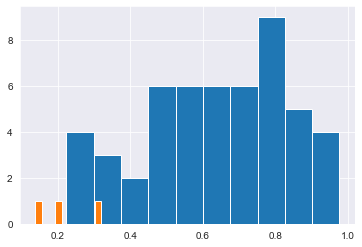

In [71]:
plt.hist(val_ds.loc[val_ds.target != 'new'].class_name_proba)
plt.hist(val_ds.loc[val_ds.target == 'new'].class_name_proba)

In [72]:
val_ds.loc[val_ds.class_name_proba < 0.2,'class_name'] = 'new'

In [73]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.8287619047619047

Как мы видим, после добавления метки 'new' значение метрики возрасло

### сохранение модели

переобучим модель на всей тренировочной выборке, так как мы исключали классы для валидации

In [74]:
X = make_x(train_df, col='intens')
y = np.array(train_df['strain'])
model = SVC(gamma='auto', kernel='sigmoid', probability=True)
clf = make_pipeline(StandardScaler(), model)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='sigmoid', probability=True))])

In [85]:
swmPickle = open('models/baseline_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)   

## Набор бинарных классификатров для каждого тарегта

In [76]:
X = make_x(train_ds, col='intens')
# X_pred = make_x(val_ds, col='intens')

In [77]:
# делаем бинарных тарегет для каждого класса
Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

In [78]:
# сохраняем порядок классов
class_order = train_ds.strain.unique()

так как негативных примеров для каждого таргета в разы больше положительных, оставим в выборке только примеры в соотношении 3:1 (негативные:положительные)

In [79]:
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = SVC(gamma='scale', probability=True)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    res.append(clf.predict_proba(X_pred)[:,1])

### проверяем качество модели на валидационной выборке

In [80]:
res = np.array(res).T

In [81]:
# выбираем класс с наибльшей вероятностью или ставим 0, если веротяность меньше 0.5
class_name = []
for res_i in res:
    if max(res_i) > 0.5:
        class_name.append(class_order[np.where(res_i == max(res_i))[0]].item())
    else:
        class_name.append('new')

In [82]:
val_ds.loc[:,'class_name'] = class_name

In [83]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9348571428571428

Данная модель показала самое высокое значение метрики, поэтому берем ее как бейзлайн для данной задачи.

### сохраняем модели

In [84]:
# переобучаем на полной выборке
res = []
for i,y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))
    
    model = SVC(gamma='scale', probability=True)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])
    # save model
    strain = class_order[i]
    pickle.dump(clf, open(f'models/baseline_clf_{strain}.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/baseline_clf_Staphilococcus aureus_4 948.pkl'

# <center> Формат решения <center>

В проверяющую систему необходимо отправить код алгоритма, запакованный в ZIP-архив. Архив должен содержать следующие файлы: 
 * solution.py -- файл с кодом запуска решения
 * models/ -- директория, где хранятся обученные модели
 * requiremnts.txt -- необходимые библиотеки для запуска решения
 * \*.py -- вспомогательные модули
 * metadata.json  -- обязательный файл для запуска докера, который содержит название docker image и команду для расчета предсказаний (см. описание задачи)
 
Решение должно быть реализовано в виде программы, которая на вход принимает файл `test.xlsx` и на выходе выдает CSV таблицу (`results.csv`). Файл `results.csv` должен в обязательном порядке содержать поле `class_name`  -- предсказанный класс (название штамма бактерии или метка 'new')